In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import datetime
import pandas as pd

from pandas import read_csv
from influxdb import InfluxDBClient
from keras.models import load_model
from scipy.fftpack import fft
from numba import jit
from sklearn.preprocessing import MinMaxScaler
from fastsst.util.linear_algebra import power_method, lanczos, eig_tridiag

In [9]:
client = InfluxDBClient(host = 'sensorwebturing.engr.uga.edu', port = 8086)
client.switch_database("SaTCtestbed")

In [ ]:
directory = r'/content/drive/MyDrive/Case_Study_1_BearingFault_Data/Data_csv'
os.listdir(directory)
os.chdir('/content/drive/MyDrive/Case_Study_1_BearingFault_Data/Data_csv')
# f_s, Nn, num_time_periods, dataWindow =2000, 200, 20, 400 #parameter definition
# #featuredata = np.zeros((len(os.listdir(directory))*length_data),15*num_time_periods)
# #labeldata = np.zeros(((len(os.listdir(directory))*length_data),4)
time_len=20000
data_arrange=np.zeros((20000,10,9))
j=-1
for filename in os.listdir(directory):
  if(filename.endswith("csv")):
    j=j+1
    print(filename)
    dataCollectIni = read_csv(filename,header=None).iloc[::10,1:] #obtain the current waveform
    dataCollect = dataCollectIni.values
    dataCollect = dataCollect[:,[0,1,2,4,5,6,7,8,9]]
    dataCollect = dataCollect.astype(float)
    for i in range(9):
      data_arrange[:,j,i]=dataCollect[:,i]

20211006_type_1_10.csv
20211006_type_1_50.csv
20211006_type_2_10.csv
20211006_type_2_50.csv
20211006_type_3_10.csv
20211006_type_3_50.csv
20211006_type_4_10.csv
20211006_type_4_50.csv
20211006_type_5_10.csv
20211006_type_5_50.csv


In [1]:
# import os
# os.chdir('/content/drive/MyDrive/singular-spectrum-transformation-master')


/home/sensorweb/Desktop/SaTC_testbed/stepstone_attack/attack_detection/fastsst/sst.py:199: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  _, s, _ = np.linalg.svd(U_test[:, :n_components].T @
/home/sensorweb/anaconda3/lib/python3.8/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


In [2]:
####### The input could only have the first decision score after the start data comes in

In [3]:

class SingularSpectrumTransformation():
    """SingularSpectrumTransformation class."""

    def __init__(self, win_length, x0, n_components=5, order=None, lag=None,
                 is_scaled=False, use_lanczos=True, rank_lanczos=None, eps=1e-3):
        """Change point detection with Singular Spectrum Transformation.
        Parameters
        ----------
        win_length : int
            window length of Hankel matrix.
        n_components : int
            specify how many rank of Hankel matrix will be taken.
        order : int
            number of columns of Hankel matrix.
        lag : int
            interval between history Hankel matrix and test Hankel matrix.
        is_scaled : bool
            if false, min-max scaling will be applied(recommended).
        use_lanczos : boolean
            if true, Lanczos method will be used, which makes faster.
        rank_lanczos : int
            the rank which will be used for lanczos method.
            for the detail of lanczos method, see [1].
        eps : float
            specify how much noise will be added to initial vector for
            power method.
            (FELIX: FEedback impLIcit kernel approXimation method)
            for the detail, see [2].
        References
        ----------
        [1]: Tsuyoshi Ide et al., Change-Point Detection using Krylov Subspace Learning
        [2]: Tsuyoshi Ide, Speeding up Change-Point Detection using Matrix Compression (Japanse)
        """
        self.win_length = win_length
        self.n_components = n_components
        self.order = order
        self.lag = lag
        self.is_scaled = is_scaled
        self.use_lanczos = use_lanczos
        self.rank_lanczos = rank_lanczos
        self.eps = eps

    def score_online(self, x):
        """Calculate anomaly score (offline).
        Parameters
        ----------
        x : 1d numpy array
            input time series data.
        Returns
        -------
        score : 1d array
            change point score.
        """
        if self.order is None:
            # rule of thumb
            self.order = self.win_length
        if self.lag is None:
            # rule of thumb
            self.lag = self.order // 2
        if self.rank_lanczos is None:
            # rule of thumb
            if self.n_components % 2 == 0:
                self.rank_lanczos = 2 * self.n_components
            else:
                self.rank_lanczos = 2 * self.n_components - 1

        assert isinstance(x, np.ndarray), "input array must be numpy array."
        assert x.ndim == 1, "input array dimension must be 1."
        assert isinstance(self.win_length, int), "window length must be int."
        assert isinstance(self.n_components, int), "number of components must be int."
        assert isinstance(self.order, int), "order of partial time series must be int."
        assert isinstance(self.lag, int), "lag between test series and history series must be int."
        assert isinstance(self.rank_lanczos, int), "rank for lanczos must be int."
        # assert self.win_length + self.order + self.lag < x.size, "data length is too short."

        # all values should be positive for numerical stabilization
        # if not self.is_scaled:
        #     x_scaled = MinMaxScaler(feature_range=(1, 2))\
        #         .fit_transform(x.reshape(-1, 1))[:, 0]
        # else:
        x_hist = x[:self.win_length-self.lag]
        x_new = x[self.lag:]
        score, x1 = _score_online(x_hist, x_new, x0, self.order,
            self.win_length, self.lag, self.n_components, self.rank_lanczos,
            self.eps, use_lanczos=self.use_lanczos)

        return score, x1

@jit(nopython=True)
def _score_online(x, y, x0, order, win_length, lag, n_components, rank, eps, use_lanczos):
    """Core implementation of offline score calculation."""
    # start_idx = win_length + order + lag + 1
    # end_idx = x.size + 1



    score = np.zeros(1)
    # for t in range(start_idx, end_idx):
    # compute score at each index

    # get Hankel matrix
    X_history = _create_hankel(x, order,
        start=order,
        end=win_length-lag)
    X_test = _create_hankel(y, order,
        start=order,
        end=win_length-lag)

    if use_lanczos:
        score, x1 = _sst_lanczos(X_test, X_history, n_components,
                                      rank, x0)
        # update initial vector for power method
        x0 = x1 + eps * np.random.rand(x0.size)
        x0 /= np.linalg.norm(x0)
    else:
        score = _sst_svd(X_test, X_history, n_components)

    return score,x0

@jit(nopython=True)
def _score_offline(x, order, win_length, lag, n_components, rank, eps, use_lanczos):
    """Core implementation of offline score calculation."""
    start_idx = win_length + order + lag + 1
    end_idx = x.size + 1

    # initialize vector for power method
    x0 = np.empty(order, dtype=np.float64)
    x0 = np.random.rand(order)
    x0 /= np.linalg.norm(x0)

    score = np.zeros_like(x)
    for t in range(start_idx, end_idx):
        # compute score at each index

        # get Hankel matrix
        X_history = _create_hankel(x, order,
            start=t - win_length - lag,
            end=t - lag)
        X_test = _create_hankel(x, order,
            start=t - win_length,
            end=t)

        if use_lanczos:
            score[t-1], x1 = _sst_lanczos(X_test, X_history, n_components,
                                          rank, x0)
            # update initial vector for power method
            x0 = x1 + eps * np.random.rand(x0.size)
            x0 /= np.linalg.norm(x0)
        else:
            score[t-1] = _sst_svd(X_test, X_history, n_components)

    return score


@jit(nopython=True)
def _create_hankel(x, order, start, end):
    """Create Hankel matrix.
    Parameters
    ----------
    x : full time series
    order : order of Hankel matrix
    start : start index
    end : end index
    Returns
    -------
    2d array shape (window length, order)
    """
    win_length = end - start
    X = np.empty((win_length, order))
    for i in range(order):
        X[:, i] = x[(start - i):(end - i)]
    return X


@jit(nopython=True)
def _sst_lanczos(X_test, X_history, n_components, rank, x0):
    """Run sst algorithm with lanczos method (FELIX-SST algorithm)."""
    P_history = X_history.T @ X_history
    P_test = X_test.T @ X_test
    # calculate the first singular vec of test matrix
    u, _, _ = power_method(P_test, x0, n_iter=1)
    T = lanczos(P_history, u, rank)
    vec, val = eig_tridiag(T)
    return 1 - (vec[0, :n_components] ** 2).sum(), u


@jit("f8(f8[:,:],f8[:,:],u1)", nopython=True)
def _sst_svd(X_test, X_history, n_components):
    """Run sst algorithm with svd."""
    U_test, _, _ = np.linalg.svd(X_test, full_matrices=False)
    U_history, _, _ = np.linalg.svd(X_history, full_matrices=False)
    _, s, _ = np.linalg.svd(U_test[:, :n_components].T @
        U_history[:, :n_components], full_matrices=False)
    return 1 - s[0]

<ipython-input-3-267f1df1c306>:192: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  _, s, _ = np.linalg.svd(U_test[:, :n_components].T @
/home/sensorweb/anaconda3/lib/python3.8/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


In [5]:
order=50
win_length=200
lag=50
pre_len = order + win_length + lag
start=dataCollect[:pre_len,:]

NameError: name 'dataCollect' is not defined

In [ ]:
Score_start=np.zeros(1)
# initialize vector for power method
x0 = np.empty(order, dtype=np.float64)
x0 = np.random.rand(order)
x0 /= np.linalg.norm(x0)
for i in [0,1,2]:  # 0,1,2,4,5,6,7,8,9
    x=data_arrange[:,2,i]         #### order 50, lag 50, n_components 2
    score_start, x0 = SingularSpectrumTransformation(win_length=win_length, x0=x0, n_components=2,order=order, lag=order,is_scaled=True).score_online(start[:,i])
    Score_start=score_start+Score_start

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


At time 4891 , the anomaly starts
At time 10064 , the anomaly ends


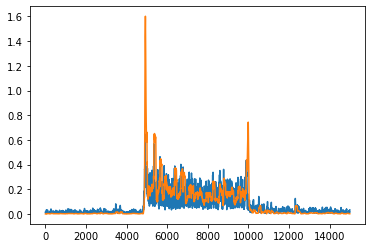

In [ ]:
from scipy.fftpack.basic import ifft
import matplotlib.pyplot as plt

windowSize=15000
stream=dataCollect[pre_len:pre_len+windowSize,3]

lastdata=start[:,3]

Score=np.zeros(windowSize)
var_score=np.zeros(windowSize)

# det = BayesOnline()
# for i in range(pre_len):
#   det.find_changepoints(lastdata, 3, 0.5)
# det.update(lastdata[i,3])
thres1=0.4 #(normally, thres2 < thres1)
thres2=0.05
state=0
move=100
# thres=max(var_score[:4000])
for j in range(windowSize):
  # print(j)
  data=np.concatenate((lastdata[1:], stream[j]), axis=None)
  score, x0 = SingularSpectrumTransformation(win_length=win_length, x0=x0, n_components=2,order=order, lag=order,is_scaled=True).score_online(data)
  Score[j]=score*10**5
  lastdata=data
  var_score[j]=50*np.var(Score[(j-move):j])
  if var_score[j] > thres1 and state==0:   
    print("At time" , j , ", the anomaly starts") 
    state=1 
  elif var_score[j] < thres2 and state==1:  
    print("At time" , j , ", the anomaly ends")
    state=0
  else:
    pass
plt.plot(Score)
plt.plot(var_score)